# Part-1 Prediction of close prices

#### Installing/Updating Yfinance

In [1]:
!pip install --upgrade yfinance

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.55)


#### Importing Yfinance Library

In [2]:
import yfinance as yf
print("yfinance imported")
!pip show yfinance

yfinance imported
Name: yfinance
Version: 0.1.55
Summary: Yahoo! Finance market data downloader
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.6/dist-packages
Requires: requests, lxml, multitasking, numpy, pandas
Required-by: 


#### Downloading stock details of Apple company from 1st Jan 2001 to 10th Nov 2020

In [3]:

apple_df = yf.download('AAPL', 
                      start='2001-01-01', 
                      end='2020-10-11')
apple_df.sample(5)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-09,38.467499,38.720001,38.362499,38.497501,36.681641,156521600
2013-02-15,16.744642,16.791430,16.425714,16.434286,14.411122,391745200
2008-04-11,5.454286,5.475000,5.228571,5.255000,4.541052,1210076000
2002-10-29,0.278036,0.283571,0.267143,0.275714,0.238256,259179200
2005-06-10,1.335714,1.335714,1.268571,1.278929,1.105172,678932800


#### Plotting Close price History

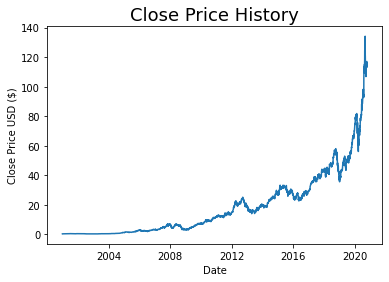

In [4]:
import matplotlib.pyplot as plt

plt.title('Close Price History', fontsize=18)
plt.plot(apple_df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

#### Preparing Data

In [5]:
import numpy as np
#Create a new dataframe with only the 'Close column
data = apple_df.filter(['Close'])
date = apple_df.filter(['Date'])

#Convert the dataframe to a numpy array
dataset = data.values
date_dataset = date.values

#Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))
training_date_len = int(np.ceil( len(date_dataset) * .8 ))

print(training_date_len)
training_data_len

3980


3980

#### Scaling Data

In [6]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data.shape

(4975, 1)

#### Creating Train data

In [7]:
#Create the training data set
train_data = scaled_data[0:int(training_data_len), :]

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

print(x_train.shape)
print(y_train.shape)

(3920, 60, 1)
(3920,)


#### Model Training

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (6, 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
40/40 [==============================] - 0s 10ms/step - loss: 0.0011
Epoch 2/10
40/40 [==============================] - 0s 8ms/step - loss: 2.5136e-05
Epoch 3/10
40/40 [==============================] - 0s 8ms/step - loss: 1.7749e-05
Epoch 4/10
40/40 [==============================] - 0s 8ms/step - loss: 1.7049e-05
Epoch 5/10
40/40 [==============================] - 0s 8ms/step - loss: 1.6740e-05
Epoch 6/10
40/40 [==============================] - 0s 8ms/step - loss: 1.7252e-05
Epoch 7/10
40/40 [==============================] - 0s 8ms/step - loss: 1.6226e-05
Epoch 8/10
40/40 [==============================] - 0s 8ms/step - loss: 1.5502e-05
Epoch 9/10
40/40 [==============================] - 0s 8ms/step - loss: 1.6134e-05
Epoch 10/10
40/40 [==============================] - 0s 8ms/step - loss: 1.5387e-05


#### Creating Test Data
#### Evaluating Model
#### Calculating RMSE 

In [9]:
#Create the testing data set
#Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3.9250629420232945

#### Plotting Predicted Data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


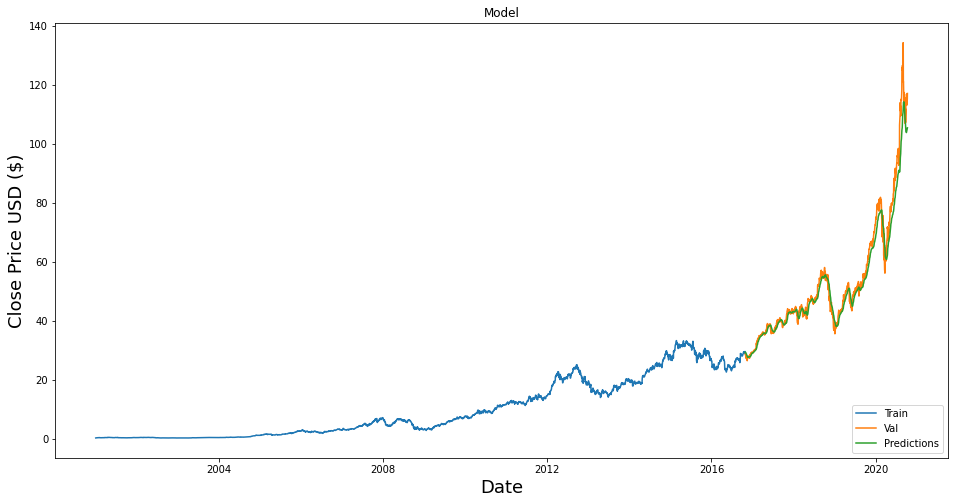

In [10]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

#### Printing Actual values and Predicted Values

In [11]:
print(valid)

                 Close  Predictions
Date                               
2016-10-27   28.620001    29.313379
2016-10-28   28.430000    29.302492
2016-10-31   28.385000    29.261406
2016-11-01   27.872499    29.200253
2016-11-02   27.897499    29.105265
...                ...          ...
2020-10-05  116.500000   104.420532
2020-10-06  113.160004   104.726906
2020-10-07  115.080002   104.925980
2020-10-08  114.970001   105.132843
2020-10-09  116.970001   105.325935

[995 rows x 2 columns]


# Part-2 Sentiment analysis of News Headline
#### (classifying using Clustering method)  

#### Importing Data from website

In [12]:
import pandas as pd 
news_df = pd.read_csv('https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/DPQMQH/P2Z4PM')

print(news_df.head())
print(news_df.tail())

   publish_date  ...                                      headline_text
0      20010101  ...  win over cena satisfying but defeating underta...
1      20010102  ...  Status quo will not be disturbed at Ayodhya; s...
2      20010102  ...                Fissures in Hurriyat over Pak visit
3      20010102  ...              America's unwanted heading for India?
4      20010102  ...                 For bigwigs; it is destination Goa

[5 rows x 3 columns]
         publish_date  ...                                      headline_text
3297167      20200630  ...      why tiktok removed 1 65 crore videos in india
3297168      20200630  ...  apurva asrani calls alia bhatts mother soni ra...
3297169      20200630  ...  kangana ranaut gets a doll version of herself ...
3297170      20200630  ...  meezaan jaffrey reminisces his childhood days ...
3297171      20200630  ...  prabhas20 titled as radhe shyam prabhas and po...

[5 rows x 3 columns]


#### Changing Datatype of Date column

In [13]:
news_df["publish_date"] = pd.to_datetime(news_df["publish_date"].astype(str), format='%Y%m%d')
news_df.rename(columns = {"publish_date":"Date"}, inplace = True) 
news_df.head()

,Date,headline_category,headline_text
0,2001-01-01,sports.wwe,win over cena satisfying but defeating underta...
1,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...
2,2001-01-02,unknown,Fissures in Hurriyat over Pak visit
3,2001-01-02,unknown,America's unwanted heading for India?
4,2001-01-02,unknown,For bigwigs; it is destination Goa


Deleting duplicate Headlines

In [14]:
news_df[news_df['headline_text'].duplicated(keep=False)].sort_values('headline_text').head(10)

,Date,headline_category,headline_text
423176,2006-09-15,unknown,Umrao Jaan is not a remake
423053,2006-09-15,entertainment.hindi.bollywood,Umrao Jaan is not a remake
421279,2006-09-06,india,Vande Mataram not to be sung by Sikhs
421376,2006-09-06,unknown,Vande Mataram not to be sung by Sikhs
3176865,2019-11-03,sports.off-the-field,#Airpocalypse: Why visiting cricket teams 'cho...
3176859,2019-11-03,city.delhi,#Airpocalypse: Why visiting cricket teams 'cho...
2485689,2016-11-20,city.delhi,#CashCrunch: Paan; chai and Sabzi kiosks go ca...
2485706,2016-11-20,city.gurgaon,#CashCrunch: Paan; chai and Sabzi kiosks go ca...
2485707,2016-11-20,city.noida,#CashCrunch: Paan; chai and Sabzi kiosks go ca...
2872175,2018-05-28,entertainment.kannada.movies.news,#Chamak music lands Judah Sandhy an Allu Siris...


In [15]:
news_df = news_df.drop_duplicates('headline_text')

#### Dropping Date and Headline category column

In [16]:
news_df_n = news_df.drop(['Date', 'headline_category'], axis=1)
news_df_n.shape

(3082589, 1)

#### Data Preprocessing

In [19]:
df = news_df_n[:20000]

In [20]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [21]:
print(df['headline_text'][0][-50:])
preprocessor(df['headline_text'][0][-50:])

fying but defeating undertaker bigger roman reigns


'fying but defeating undertaker bigger roman reigns'

In [22]:
df['headline_text'] = df['headline_text'].apply(preprocessor)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [23]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
[w for w in tokenizer_porter(df['headline_text'][0][-50:])[-10:] if w not in stop]

['fy', 'defeat', 'undertak', 'bigger', 'roman', 'reign']

In [26]:
df.headline_text

0        win over cena satisfying but defeating underta...
1        status quo will not be disturbed at ayodhya sa...
2                      fissures in hurriyat over pak visit
3                    america s unwanted heading for india 
4                        for bigwigs it is destination goa
                               ...                        
21659                opening for teachers in uk under fire
21660    the speaking treebrstriking the right chord wi...
21661                                   last date extended
21662                     spending on tourism insufficient
21663                        tom and nicole keep it secret
Name: headline_text, Length: 20000, dtype: object

NLP
Preparing data for vectorizaion(TF-IDF)


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                       lowercase=False,
                       preprocessor=None,
                       tokenizer=tokenizer_porter,
                       use_idf=True,
                       norm='l2',
                       smooth_idf=True)

x = tfidf.fit_transform(df.headline_text)

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
print(x.shape)
#kmeans = KMeans(n_clusters=2,init='k-means++',max_iter=300,n_init=10,random_state=4)

(20000, 13571)


#### Finding Optimal Number of clusters using Elbow Method

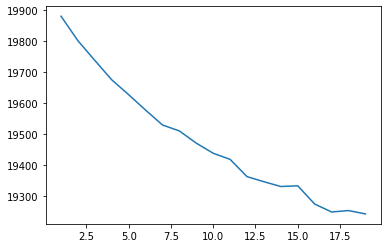

In [29]:
scores_1 = []
range_values = range(1, 20)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(x)
    scores_1.append(kmeans.inertia_)
    
plt.plot(range_values, scores_1)

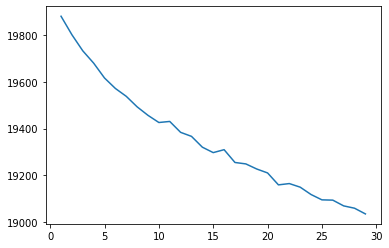

In [31]:
scores_1 = []
range_values = range(1, 30)
for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(x)
    scores_1.append(kmeans.inertia_)
    
plt.plot(range_values, scores_1)

#### Considering 10 clusters 

#### Plotting count plot of clusters

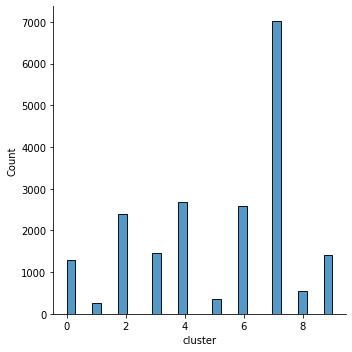

In [32]:
import seaborn as sns
kmeans = KMeans(10)
kmeans.fit(x)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(x)

news_df_cluster = pd.concat([news_df['Date'][:20000], df, pd.DataFrame({'cluster':labels})], axis = 1)
sns.displot(x='cluster', data=news_df_cluster)

In [33]:
news_df_cluster.groupby(by=['cluster']).count()

,Date,headline_text
cluster,,
0.0,1188,1188
1.0,237,237
2.0,2223,2223
3.0,1363,1363
4.0,2476,2476
5.0,324,324
6.0,2377,2377
7.0,6455,6455
8.0,488,488


#### Considering 15 clusters

In [34]:
kmeans = KMeans(15)
kmeans.fit(x)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(x)

news_df_cluster = pd.concat([news_df['Date'][:20000], df, pd.DataFrame({'cluster':labels})], axis = 1)

#### Plotting count plot of clusters

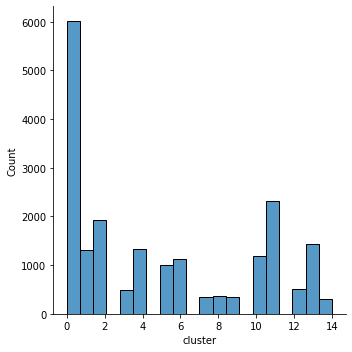

In [35]:
sns.displot(x='cluster', data=news_df_cluster)

In [36]:
news_df_cluster.groupby(by=['cluster']).count()

,Date,headline_text
cluster,,
0.0,5544,5544
1.0,1211,1211
2.0,1787,1787
3.0,455,455
4.0,1239,1239
5.0,901,901
6.0,1028,1028
7.0,319,319
8.0,347,347


# Plot of 8 clusters

In [37]:
kmeans = KMeans(8)
kmeans.fit(x)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(x)

news_df_cluster = pd.concat([news_df['Date'][:20000], df, pd.DataFrame({'cluster':labels})], axis = 1)

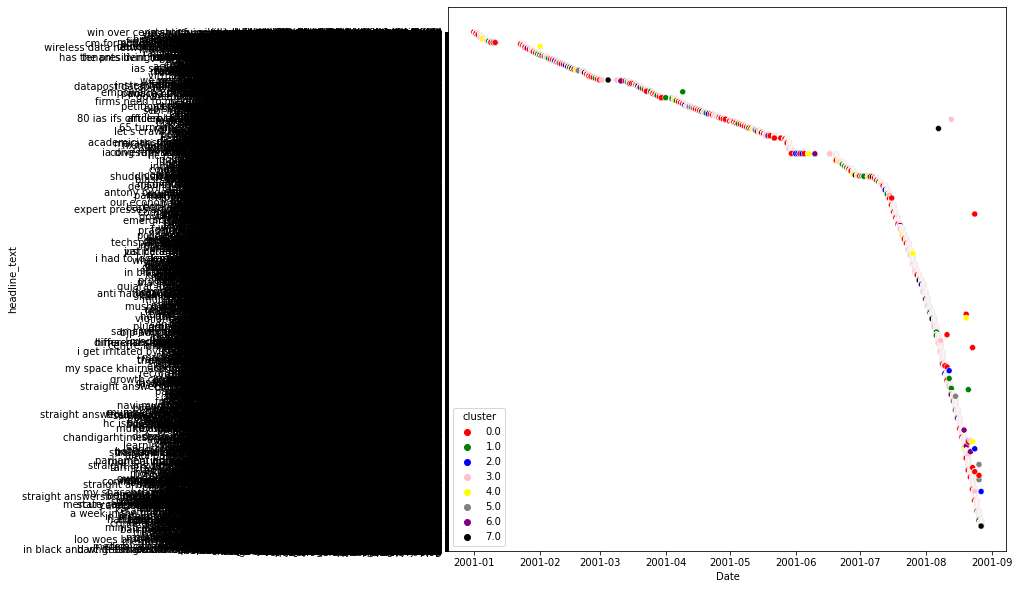

In [38]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="Date", y="headline_text", hue = "cluster", data = news_df_cluster, palette =['red','green','blue','pink','yellow','gray','purple', 'black'])
plt.show()

In [39]:
news_df_cluster.groupby(by=['cluster']).count()

,Date,headline_text
cluster,,
0.0,7359,7359
1.0,2184,2184
2.0,1762,1762
3.0,2749,2749
4.0,1405,1405
5.0,1188,1188
6.0,1422,1422
7.0,355,355


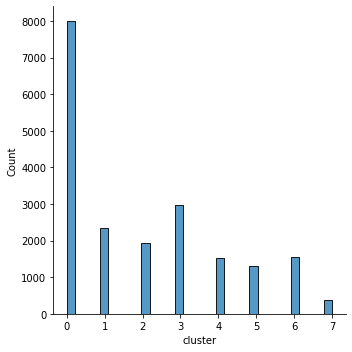

In [40]:
sns.displot(x='cluster', data=news_df_cluster)